In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import torch

# %matplotlib widget

In [2]:
# Gets best metric for all entries with same name
def get_best_metrics(df, sort_dict, metric="val_top_10_mces_dist", best_func=min, show_metric=None):
    a = sorted([(n, best_func(df[df.Name == n][metric])) for n in set(df.Name)], key=lambda x: sort_dict[x[0]])
    return [df[(df[metric] == x[1]) & (df.Name == x[0])][metric if show_metric is None else show_metric].iloc[0] for x in a]

def compareModelsBarPlot(df1, df2, models, names, label1, label2, y_labels, df1_metrics=['val_top_1_mces_dist'], df2_metrics=['val_top_10_mces_dist'], selection_metric="val_top_10_mces_dist", best_func=min, y_padding=0.05, colors=['skyblue','salmon'], same_axes=True):
    assert len(y_labels) == len(df1_metrics) == len(df2_metrics)
    
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(len(y_labels), 2, figsize=(12, 6*len(y_labels)))
    one_plot = len(y_labels) == 1
    
    sort_dict = {k: i for i, k in enumerate(models)}
    d1 = df1[df1.Name.isin(models)].copy().sort_values(by=['Name'], key=lambda x: x.map(sort_dict))
    d2 = df2[df2.Name.isin(models)].copy().sort_values(by=['Name'], key=lambda x: x.map(sort_dict))

    for i, (y_label, df1_metric, df2_metric) in enumerate(zip(y_labels, df1_metrics, df2_metrics)):
        # Determine the maximum y-value across both metrics
        max_y = max(max(d1[df1_metric]), max(d2[df2_metric]))

        axes[0 if one_plot else (i, 0)].bar(names, d1[df1_metric], color=colors[0])
        axes[0 if one_plot else (i, 0)].set_title(label1)
        axes[0 if one_plot else (i, 0)].set_ylabel(y_label)
        axes[0 if one_plot else (i, 0)].set_xticks(range(len(names)))
        axes[0 if one_plot else (i, 0)].set_xticklabels(names, rotation=45, ha='right')
        if not same_axes:
            max_y = max(d1[df1_metric])
        axes[0 if one_plot else (i, 0)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit
        
        best_metrics = get_best_metrics(d2, sort_dict, selection_metric, show_metric=df2_metric)
        axes[1 if one_plot else (i, 1)].bar(names, best_metrics, color=colors[1])
        axes[1 if one_plot else (i, 1)].set_title(label2)
        axes[1 if one_plot else (i, 1)].set_ylabel(y_label)
        axes[1 if one_plot else (i, 1)].set_xticks(range(len(names)))
        axes[1 if one_plot else (i, 1)].set_xticklabels(names, rotation=45, ha='right')
        if not same_axes:
            max_y = max(best_metrics)
        axes[1 if one_plot else (i, 1)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [3]:
def compareModelsWithTemp(df1, df2, models, names, label1, label2, y_labels, df1_metrics=['val_top_1_mces_dist'], df2_metrics=['val_top_10_mces_dist'], y_padding=0.05, colors=['skyblue','salmon'], same_axes=True):
    assert len(y_labels) == len(df1_metrics) == len(df2_metrics)
    
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(len(y_labels), 2, figsize=(12, 6*len(y_labels)))
    one_plot = len(y_labels) == 1
    
    sort_dict = {k: i for i, k in enumerate(models)}
    d1 = df1[df1.Name.isin(models)].copy().sort_values(by=['Name'], key=lambda x: x.map(sort_dict))
    d2 = df2[df2.Name.isin(models)].copy().sort_values(by=['Name'], key=lambda x: x.map(sort_dict))

    for i, (y_label, df1_metric, df2_metric) in enumerate(zip(y_labels, df1_metrics, df2_metrics)):
        # Determine the maximum y-value across both metrics
        max_y = max(max(d1[df1_metric]), max(d2[df2_metric]))
        axes[0 if one_plot else (i, 0)].bar(names, d1[df1_metric], color=colors[0])
        axes[0 if one_plot else (i, 0)].set_title(label1)
        axes[0 if one_plot else (i, 0)].set_ylabel(y_label)
        axes[0 if one_plot else (i, 0)].set_xticks(range(len(names)))
        axes[0 if one_plot else (i, 0)].set_xticklabels(names, rotation=45, ha='right')
        if not same_axes:
            max_y = max(d1[df1_metric])
        axes[0 if one_plot else (i, 0)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit

        for m, n in zip(models, names):
            d = d2[d2.Name == m].sort_values("temp")
            axes[1 if one_plot else (i, 1)].plot(d["temp"], d[df2_metric], 'o-', label=n)
        axes[1 if one_plot else (i, 1)].set_ylabel(y_label)
        axes[1 if one_plot else (i, 1)].set_xlabel("temperature")
        axes[1 if one_plot else (i, 1)].set_title(label2)
        if not same_axes:
            max_y = max(d2[df2_metric])
        axes[1 if one_plot else (i, 1)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit
        axes[1 if one_plot else (i, 1)].legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [17]:
def compareModelsCombinedPlots(df1, df2, models, names, label1, label2, y_labels, df1_metrics=['val_top_1_mces_dist'], df2_metrics=['val_top_10_mces_dist'], selection_metric="val_top_10_mces_dist", best_func=min, y_padding=0.05, colors=['skyblue','salmon'], same_axes=True):
    assert len(y_labels) == len(df1_metrics) == len(df2_metrics)
    
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(len(y_labels), 3, figsize=(18, 6*len(y_labels)))
    one_plot = len(y_labels) == 1
    
    sort_dict = {k: i for i, k in enumerate(models)}
    d1 = df1[df1.Name.isin(models)].copy().sort_values(by=['Name'], key=lambda x: x.map(sort_dict))
    d2 = df2[df2.Name.isin(models)].copy().sort_values(by=['Name'], key=lambda x: x.map(sort_dict))

    for i, (y_label, df1_metric, df2_metric) in enumerate(zip(y_labels, df1_metrics, df2_metrics)):
        # Determine the maximum y-value across both metrics
        max_y = max(max(d1[df1_metric]), max(d2[df2_metric]))

        axes[0 if one_plot else (i, 0)].bar(names, d1[df1_metric], color=colors[0])
        axes[0 if one_plot else (i, 0)].set_title(label1)
        axes[0 if one_plot else (i, 0)].set_ylabel(y_label)
        axes[0 if one_plot else (i, 0)].set_xticks(range(len(names)))
        axes[0 if one_plot else (i, 0)].set_xticklabels(names, rotation=45, ha='right')
        if not same_axes:
            max_y = max(d1[df1_metric])
        axes[0 if one_plot else (i, 0)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit
        
        for m, n in zip(models, names):
            d = d2[d2.Name == m].sort_values("temp")
            axes[1 if one_plot else (i, 1)].plot(d["temp"], d[df2_metric], 'o-', label=n)
        axes[1 if one_plot else (i, 1)].set_ylabel(y_label)
        axes[1 if one_plot else (i, 1)].set_xlabel("temperature")
        axes[1 if one_plot else (i, 1)].set_title(label2)
        if not same_axes:
            max_y = max(d2[df2_metric])
        axes[1 if one_plot else (i, 1)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit
        axes[1 if one_plot else (i, 1)].legend()
        
        best_metrics = get_best_metrics(d2, sort_dict, selection_metric, show_metric=df2_metric)
        axes[2 if one_plot else (i, 2)].bar(names, best_metrics, color=colors[1])
        axes[2 if one_plot else (i, 2)].set_title(label2)
        axes[2 if one_plot else (i, 2)].set_ylabel(y_label)
        axes[2 if one_plot else (i, 2)].set_xticks(range(len(names)))
        axes[2 if one_plot else (i, 2)].set_xticklabels(names, rotation=45, ha='right')
        if not same_axes:
            max_y = max(best_metrics)
        axes[2 if one_plot else (i, 2)].set_ylim(0, max_y * (1+y_padding))  # Set y-axis limit
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [4]:
import matplotlib.pyplot as plt

def compareModelsWithTemp_with_row_titles(
    df1, df2,
    models, names,
    label1, label2,
    y_labels, 
    row_titles=None,
    df1_metrics=['val_top_1_mces_dist'],
    df2_metrics=['val_top_10_mces_dist'],
    y_padding=0.05,
    colors=['skyblue', 'salmon'],
    same_axes=True,
    row_title_pad=0.08
):
    """
    Compare two DataFrames of model metrics in side-by-side subplots,
    with a supertitle above each row via SubFigure.suptitle.

    Parameters
    ----------
    df1, df2 : pandas.DataFrame
        Input metrics; df2 must have a 'temp' column.
    models : list of hashable
        Model keys to select and order.
    names : list of str
        Display names matching `models`.
    label1, label2 : str
        Titles for the left (bar) and right (line) axes.
    y_labels : list of str
        One ylabel per row.
    row_titles : list of str
        One super‐row‐title per row.
    Other parameters mirror your original function.
    """
    n = len(y_labels)
    # sort input DataFrames by `models` order
    sort_idx = {m: i for i, m in enumerate(models)}
    d1 = df1[df1.Name.isin(models)].copy().sort_values('Name', key=lambda x: x.map(sort_idx))
    d2 = df2[df2.Name.isin(models)].copy().sort_values('Name', key=lambda x: x.map(sort_idx))

    # create main figure and row‐wise subfigures
    fig = plt.figure(constrained_layout=True, figsize=(12, 6 * n))  # uses plt.figure under the hood of plt.subplots :contentReference[oaicite:3]{index=3}
    subfigs = fig.subfigures(nrows=n, ncols=1)  # new in Matplotlib 3.4.0 :contentReference[oaicite:4]{index=4}

    for i, (row_title, y_lab, m1, m2) in enumerate(zip(row_titles, y_labels, df1_metrics, df2_metrics)):
        # set the title above this row
        
        if row_titles is not None:
            subfigs[i].subplots_adjust(top=1.0 - row_title_pad)
            subfigs[i].suptitle(row_title, fontsize=16, y=1.02)  # places it immediately above the subfigure :contentReference[oaicite:5]{index=5}
        
        # make two side‐by‐side axes within this subfigure
        ax_bar, ax_line = subfigs[i].subplots(nrows=1, ncols=2, squeeze=False)[0]  # returns a 2‐D array :contentReference[oaicite:6]{index=6}

        # ---- Left: bar chart ----
        max1 = d1[m1].max()
        ax_bar.bar(names, d1[m1], color=colors[0])
        ax_bar.set_title(label1)
        ax_bar.set_ylabel(y_lab)
        ax_bar.set_xticks(range(len(names)))
        ax_bar.set_xticklabels(names, rotation=45, ha='right')
        ylim1 = max1 * (1 + y_padding)

        # ---- Right: line vs temperature ----
        max2 = 0
        for mod, nm in zip(models, names):
            tmp = d2[d2.Name == mod].sort_values('temp')
            ax_line.plot(tmp['temp'], tmp[m2], 'o-', label=nm)
            max2 = max(max2, tmp[m2].max())
        ax_line.set_title(label2)
        ax_line.set_xlabel('temperature')
        ax_line.set_ylabel(y_lab)
        ax_line.legend()
        ylim2 = max2 * (1 + y_padding)

        # optionally unify y‐limits
        if same_axes:
            shared = max(max1, max2) * (1 + y_padding)
            ax_bar.set_ylim(0, shared)
            ax_line.set_ylim(0, shared)
        else:
            ax_bar.set_ylim(0, ylim1)
            ax_line.set_ylim(0, ylim2)

    plt.show()

# Load Data

In [5]:
data_df = pd.read_csv("results_csv_files/all_models.csv")
data_df.Name

0      naive-parallel_smiles_4M_bpe_no_stereo_temp11e-1
1      naive-parallel_smiles_4M_bpe_no_stereo_temp10e-1
2      naive-parallel_smiles_4M_bpe_no_stereo_temp90e-2
3      naive-parallel_smiles_4M_bpe_no_stereo_temp80e-2
4      naive-parallel_smiles_4M_bpe_no_stereo_temp70e-2
                             ...                       
155          greedy_smiles_paper_limvocab_118Mtokenizer
156      greedy_smiles_paper_mz_shift_augmentation_2e-1
157                     greedy_smiles_transformer_paper
158            greedy_smiles_paper_118M_tokenizer_bs512
159         greedy_smiles_paper_mz_shift_augmentation_1
Name: Name, Length: 160, dtype: object

In [6]:
greedy_df = data_df[data_df.Name.str.contains('greedy')].copy()
greedy_df["Name"] = greedy_df["Name"].str.extract(r"^greedy_(?P<name>.*)")["name"]
naive_df = data_df[~data_df.Name.str.contains('greedy')].copy()
naive_df["temp"] = naive_df["Name"].str.extract(r"temp(?P<temp>\d+e-?\d+)")["temp"].astype(float)
naive_df["Name"] = naive_df["Name"].str.extract(r"^naive-parallel_(?P<name>.*)_temp")["name"]
naive_df['val_num_non_empty_preds'] = naive_df['val_num_non_empty_preds'].apply(lambda x: x / 10)
naive_df['val_num_novel_mols'] = naive_df['val_num_novel_mols'].apply(lambda x: x / 10)
naive_df['val_num_valid_mols'] = naive_df['val_num_valid_mols'].apply(lambda x: x / 10)
print(len(greedy_df), len(naive_df))

20 140


In [7]:
naive_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,accelerator,alpha,...,val_num_non_empty_preds,val_num_novel_mols,val_num_valid_mols,val_top_10_accuracy,val_top_10_max_tanimoto_sim,val_top_10_mces_dist,val_top_1_accuracy,val_top_1_max_tanimoto_sim,val_top_1_mces_dist,temp
0,smiles_4M_bpe_no_stereo,failed,-,NaN,NaN,2025-04-24T03:35:00.000Z,5861,NaN,gpu,1,...,1.0,0.231757,0.424469,0,0.153716,26.578955,0,0.045607,71.694809,1.1
1,smiles_4M_bpe_no_stereo,failed,-,NaN,NaN,2025-04-24T03:23:32.000Z,6855,NaN,gpu,1,...,1.0,0.249884,0.492763,0,0.164989,24.829069,0,0.055021,66.872559,1.0
2,smiles_4M_bpe_no_stereo,failed,-,NaN,NaN,2025-04-24T03:20:49.000Z,7679,NaN,gpu,1,...,1.0,0.263256,0.564589,0,0.173474,23.811390,0,0.066020,61.633900,0.9
3,smiles_4M_bpe_no_stereo,failed,-,NaN,NaN,2025-04-24T03:18:53.000Z,8270,NaN,gpu,1,...,1.0,0.265979,0.633399,0,0.179860,23.196741,0,0.074846,57.362808,0.8
4,smiles_4M_bpe_no_stereo,failed,-,NaN,NaN,2025-04-24T02:59:36.000Z,8878,NaN,gpu,1,...,1.0,0.265299,0.703685,0,0.185294,22.828762,0,0.085882,52.431702,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,smiles_transformer_paper,failed,-,NaN,NaN,2025-04-19T16:23:45.000Z,12242,NaN,gpu,1,...,1.0,0.578491,0.818920,0,0.182703,21.645144,0,0.096853,43.371429,0.9
146,smiles_transformer_paper,failed,-,NaN,NaN,2025-04-19T16:23:45.000Z,13914,NaN,gpu,1,...,1.0,0.568022,0.868207,0,0.185612,21.483606,0,0.104485,39.789181,0.8
147,smiles_transformer_paper,failed,-,NaN,NaN,2025-04-19T16:18:58.000Z,12368,NaN,gpu,1,...,1.0,0.504643,0.939719,0,0.186376,21.638607,0,0.117257,34.723507,0.6
148,smiles_transformer_paper,failed,-,NaN,NaN,2025-04-19T16:18:55.000Z,14080,NaN,gpu,1,...,1.0,0.542673,0.908590,0,0.186653,21.430466,0,0.111939,36.982834,0.7


In [8]:
models = naive_df.Name.unique()
print(models)

['smiles_4M_bpe_no_stereo' 'bytelevel_smiles_no_stereo' 'inchi_bpe_4m'
 'bytelevel_deepsmiles' 'deepSmiles_paper' 'selfies_paper'
 'selfies_bpe_4m' 'smiles_augmented_5' 'smiles_augmented_2'
 'smiles_augmented_1' 'layered_inchi_BPE' 'smiles118M_paper_15142'
 'smiles4M_paper_freq10' 'smiles_paper_bytelevel_tokenizer'
 'smiles_paper_no_augmentation_BPE_tokenizer'
 'smiles_paper_limvocab_118Mtokenizer' 'smiles_paper_118M_tokenizer_bs512'
 'smiles_paper_mz_shift_augmentation_2e-1'
 'smiles_paper_mz_shift_augmentation_1' 'smiles_transformer_paper']


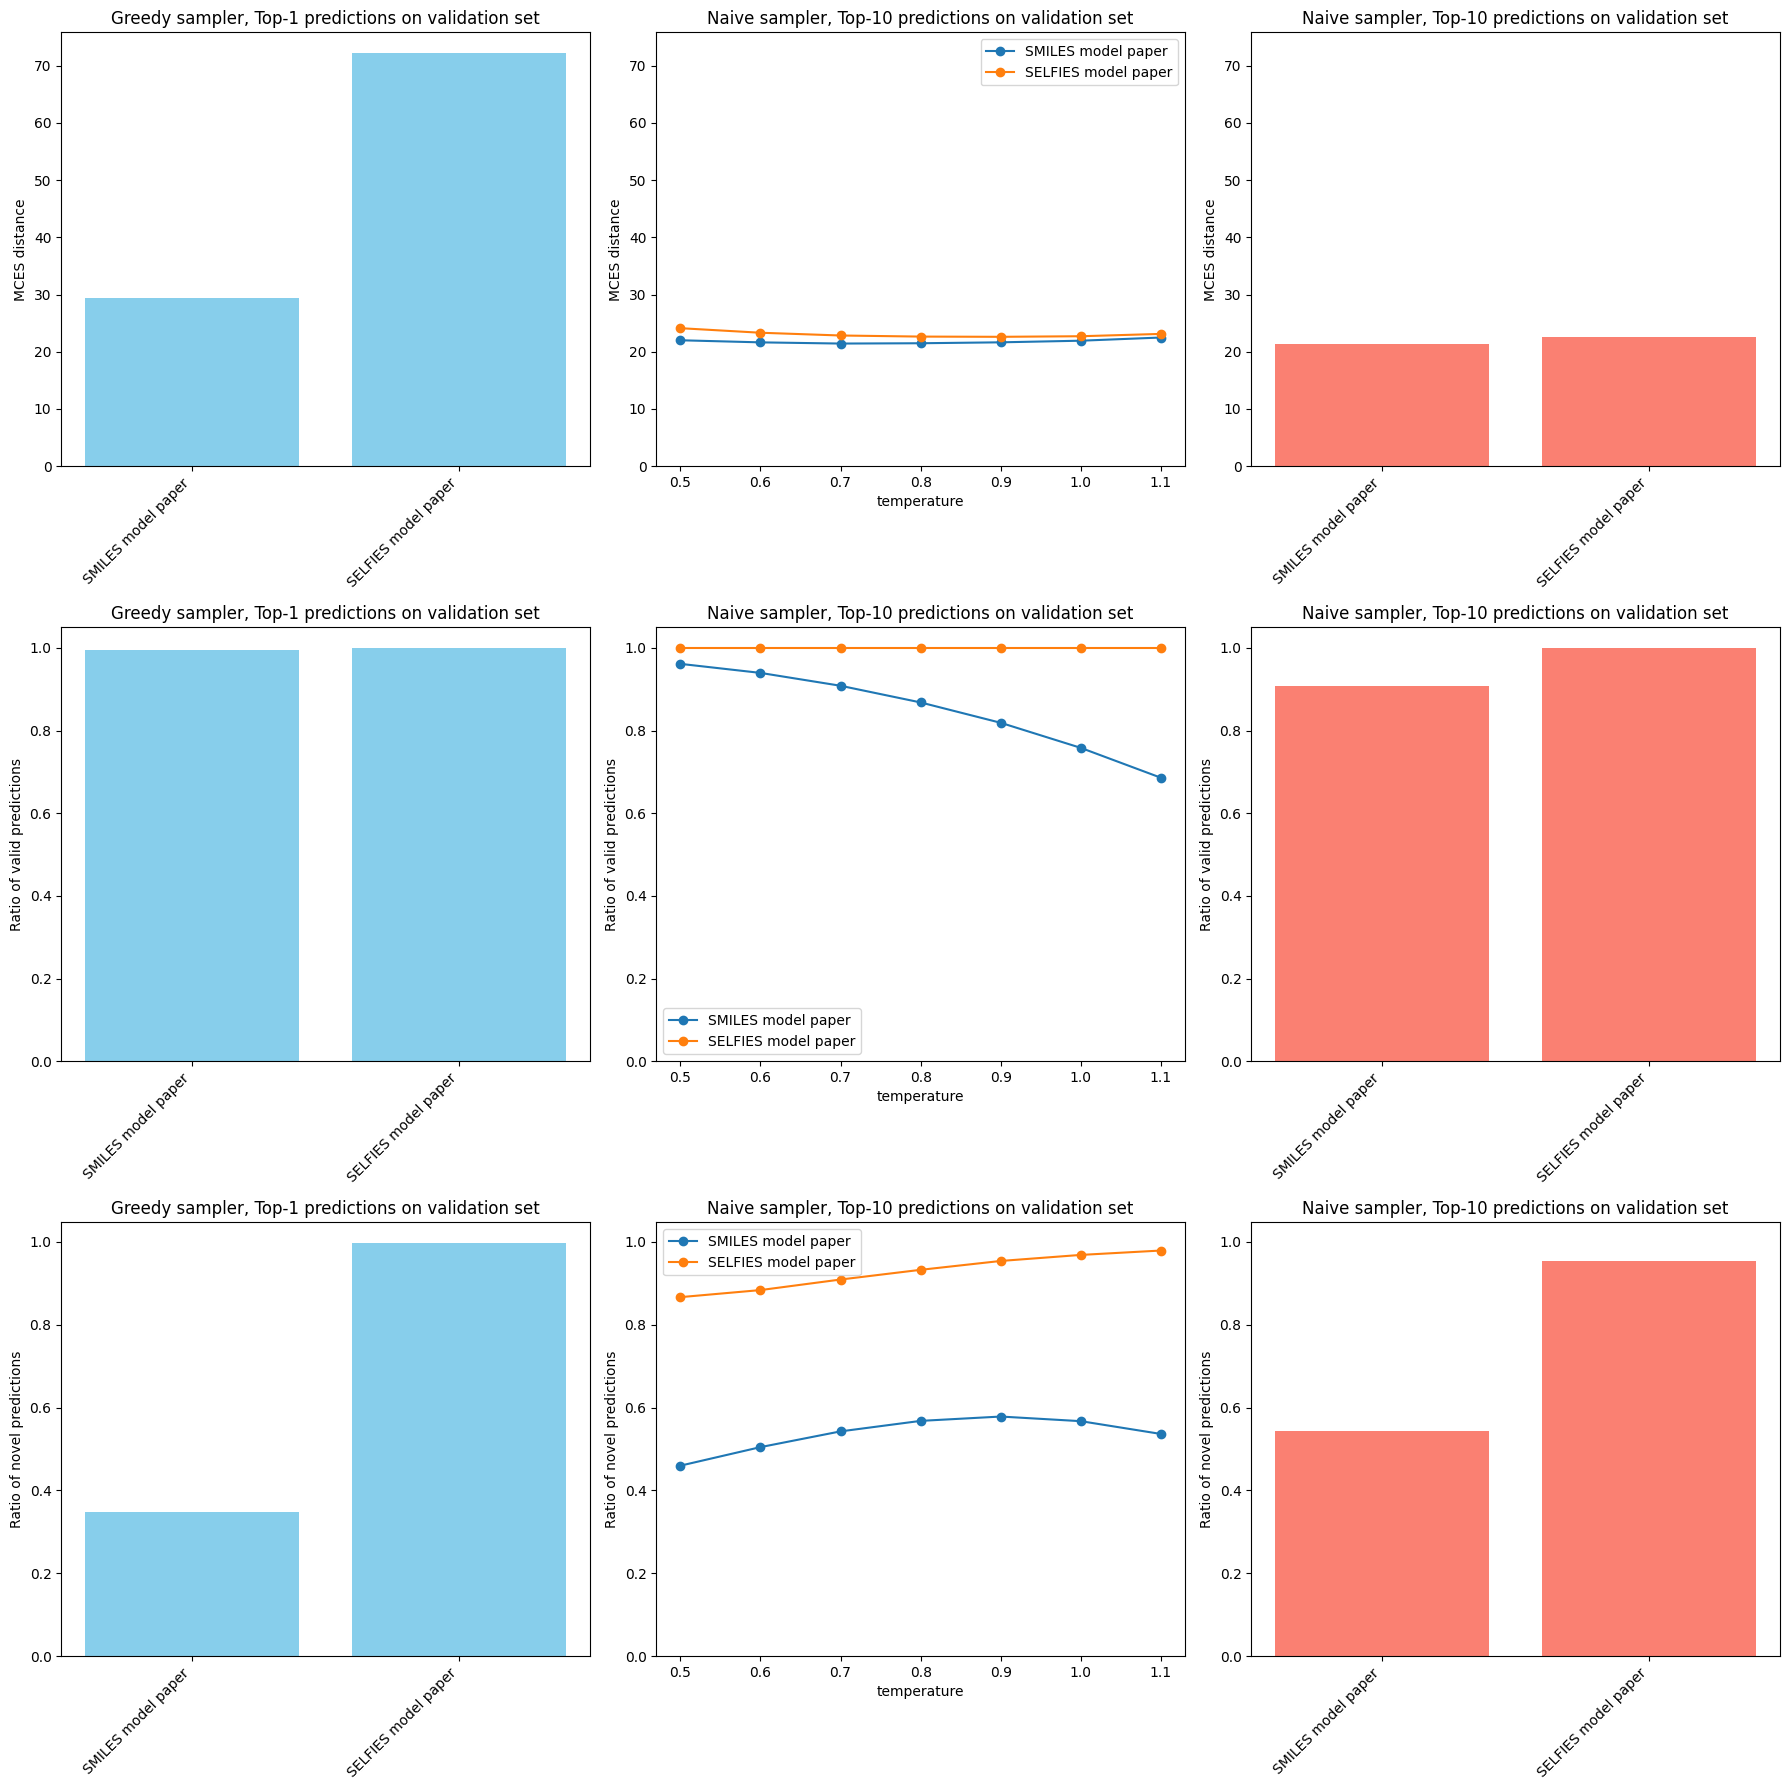

In [22]:
models = ["smiles_transformer_paper", "selfies_paper"]
names = ["SMILES model paper", "SELFIES model paper"]

compareModelsCombinedPlots(
    greedy_df, naive_df, models, names,
    "Greedy sampler, Top-1 predictions on validation set",
    "Naive sampler, Top-10 predictions on validation set",
    ["MCES distance", "Ratio of valid predictions", "Ratio of novel predictions"],
    df1_metrics=["val_top_1_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    df2_metrics=["val_top_10_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    selection_metric="val_top_10_mces_dist", best_func=min,
)

# BPE

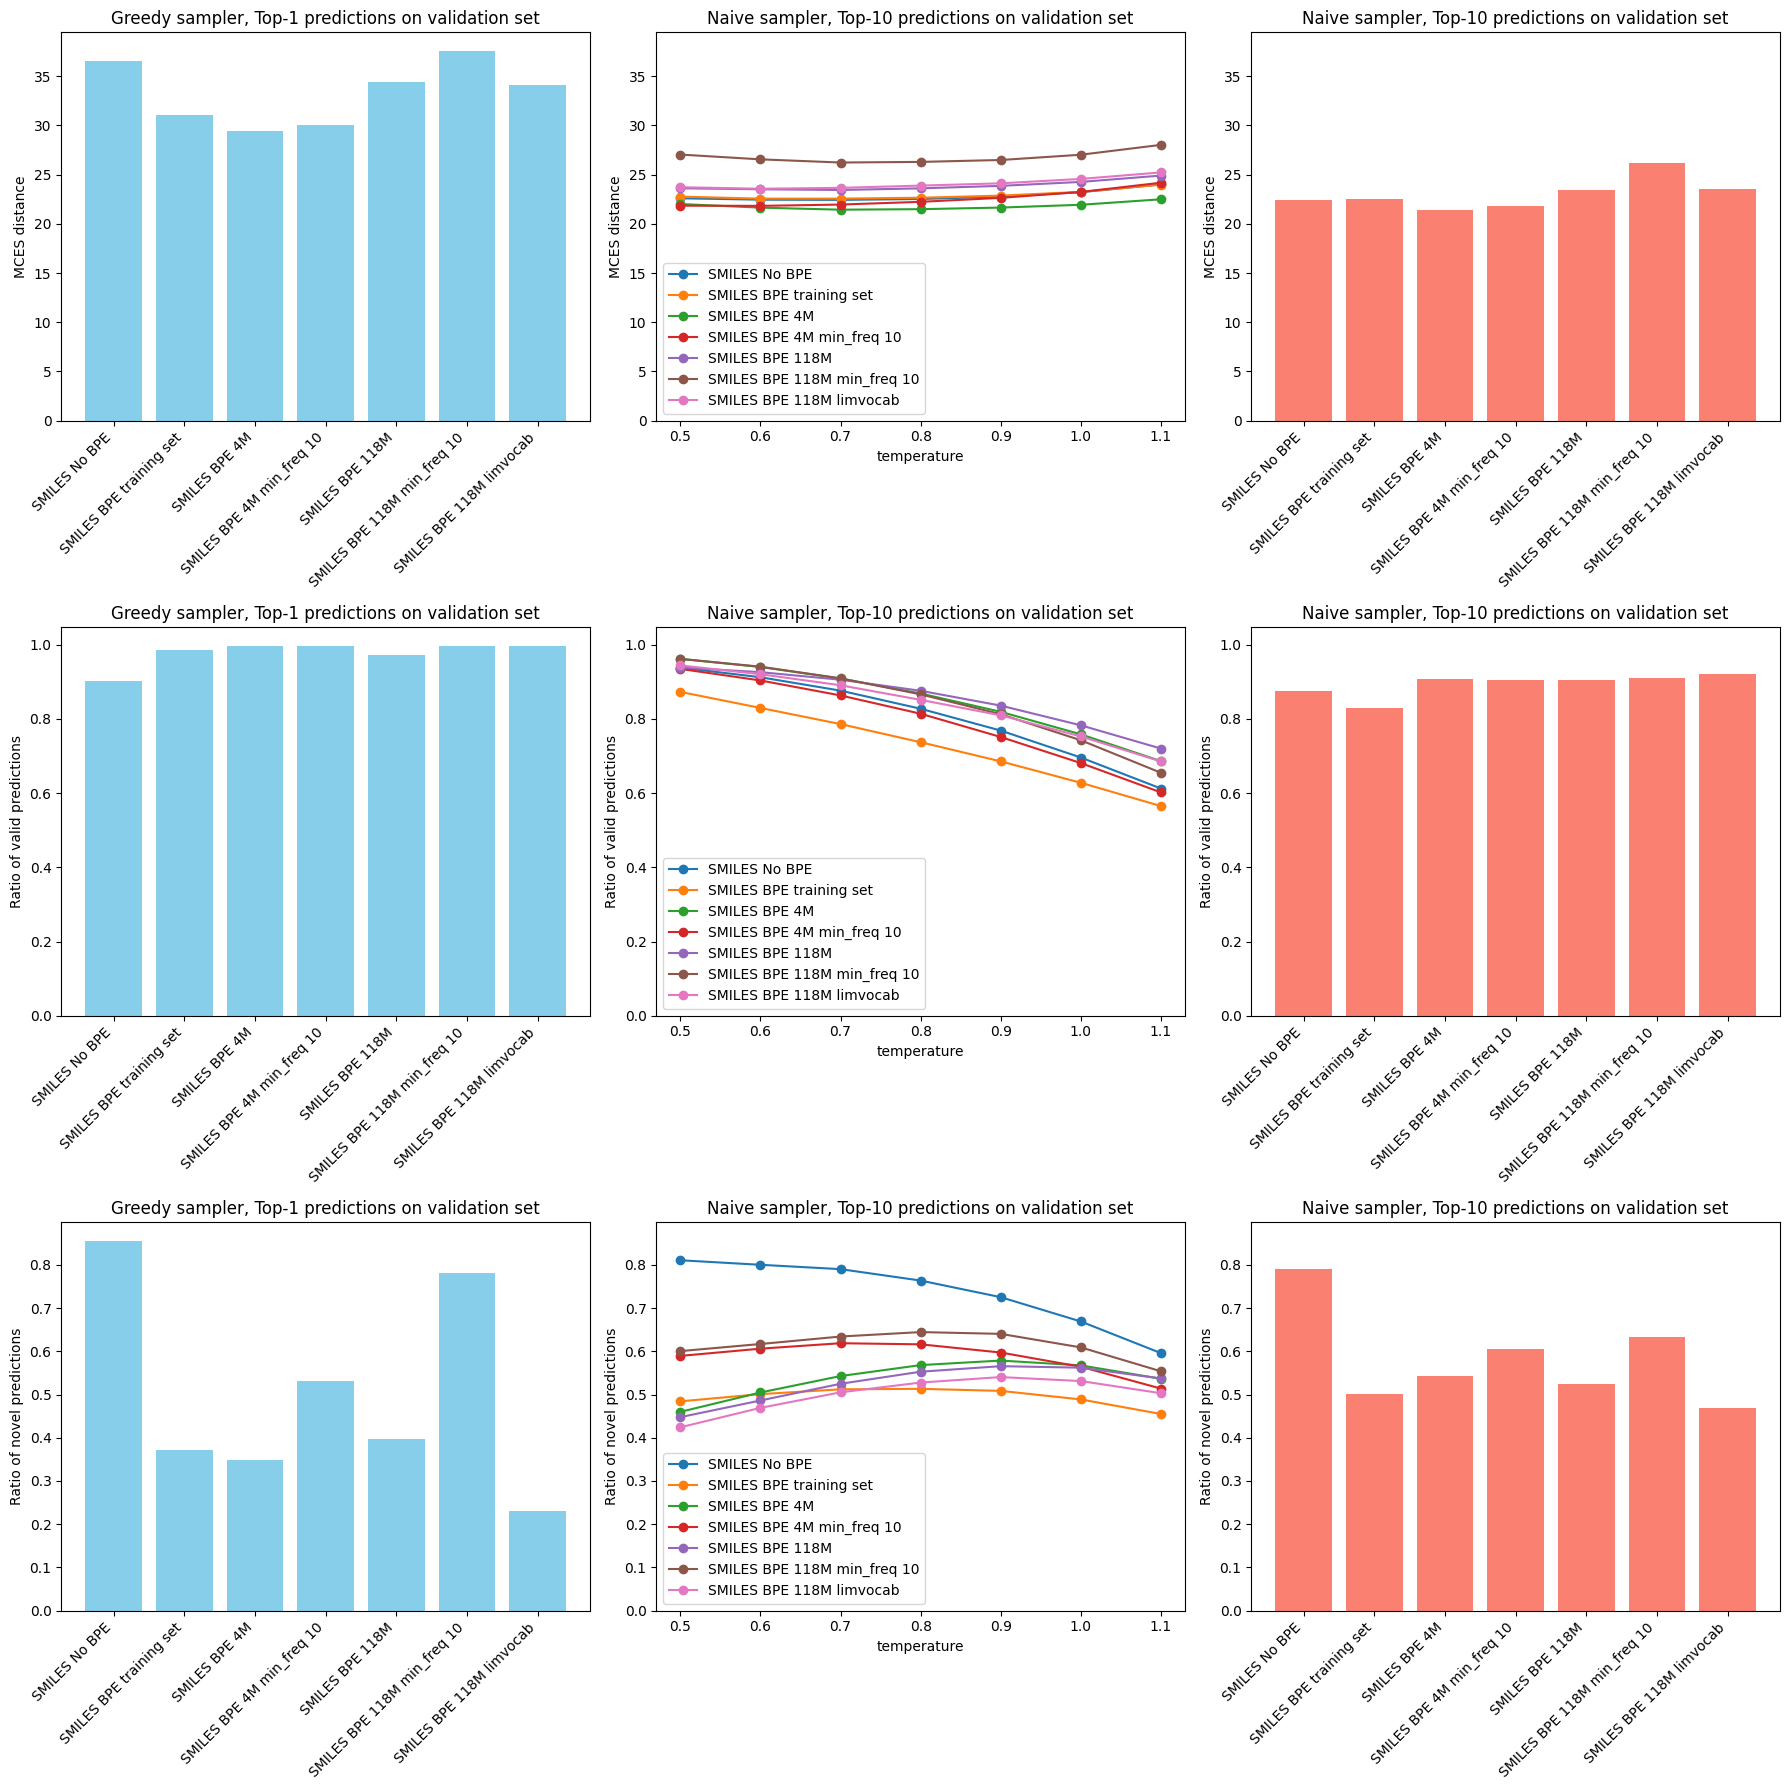

In [21]:
models = [
    'smiles_paper_bytelevel_tokenizer',
    'smiles_paper_no_augmentation_BPE_tokenizer', 
    'smiles_transformer_paper',
    'smiles4M_paper_freq10',
    'smiles_paper_118M_tokenizer_bs512',
    'smiles118M_paper_15142',
    'smiles_paper_limvocab_118Mtokenizer'
]
names = [
    "SMILES No BPE", 
    "SMILES BPE training set", 
    "SMILES BPE 4M", 
    "SMILES BPE 4M min_freq 10", 
    "SMILES BPE 118M", 
    "SMILES BPE 118M min_freq 10", 
    "SMILES BPE 118M limvocab",
]

compareModelsCombinedPlots(
    greedy_df, naive_df, models, names,
    "Greedy sampler, Top-1 predictions on validation set",
    "Naive sampler, Top-10 predictions on validation set",
    ["MCES distance", "Ratio of valid predictions", "Ratio of novel predictions"],
    df1_metrics=["val_top_1_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    df2_metrics=["val_top_10_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    selection_metric="val_top_10_mces_dist", best_func=min,
)

# SMILES synonyms

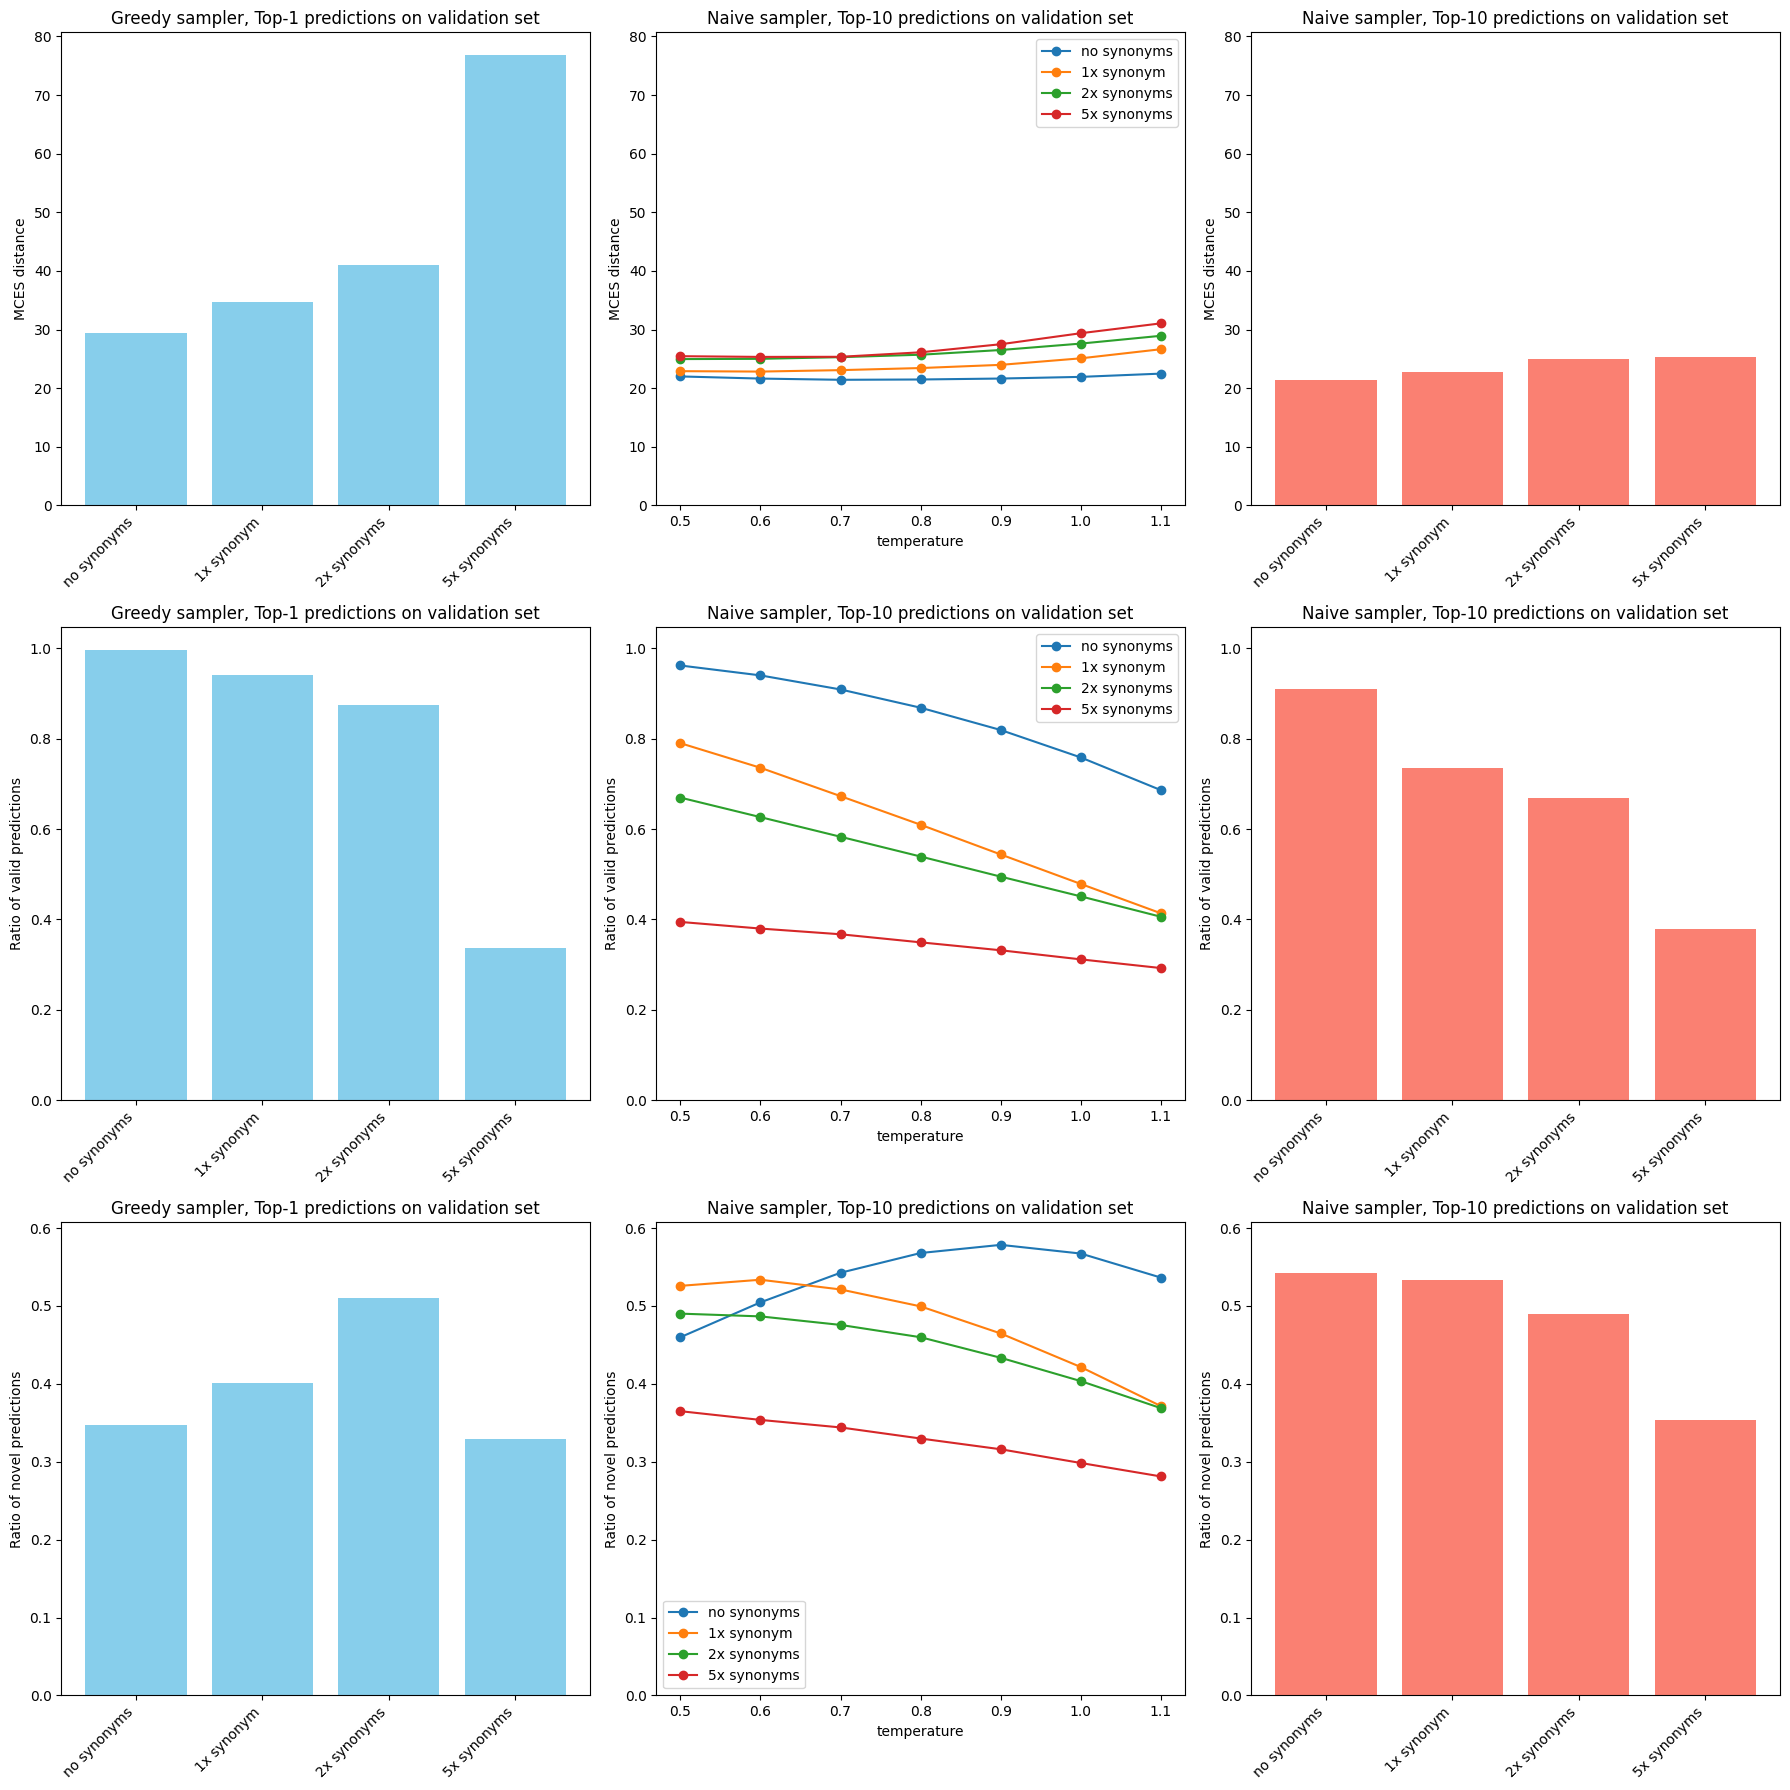

In [20]:
models = [
    'smiles_transformer_paper',
    'smiles_augmented_1',
    'smiles_augmented_2',
    'smiles_augmented_5'
]
names = ["no synonyms", "1x synonym", "2x synonyms", "5x synonyms"]

compareModelsCombinedPlots(
    greedy_df, naive_df, models, names,
    "Greedy sampler, Top-1 predictions on validation set",
    "Naive sampler, Top-10 predictions on validation set",
    ["MCES distance", "Ratio of valid predictions", "Ratio of novel predictions"],
    df1_metrics=["val_top_1_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    df2_metrics=["val_top_10_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    selection_metric="val_top_10_mces_dist", best_func=min,
)

# MZ shift

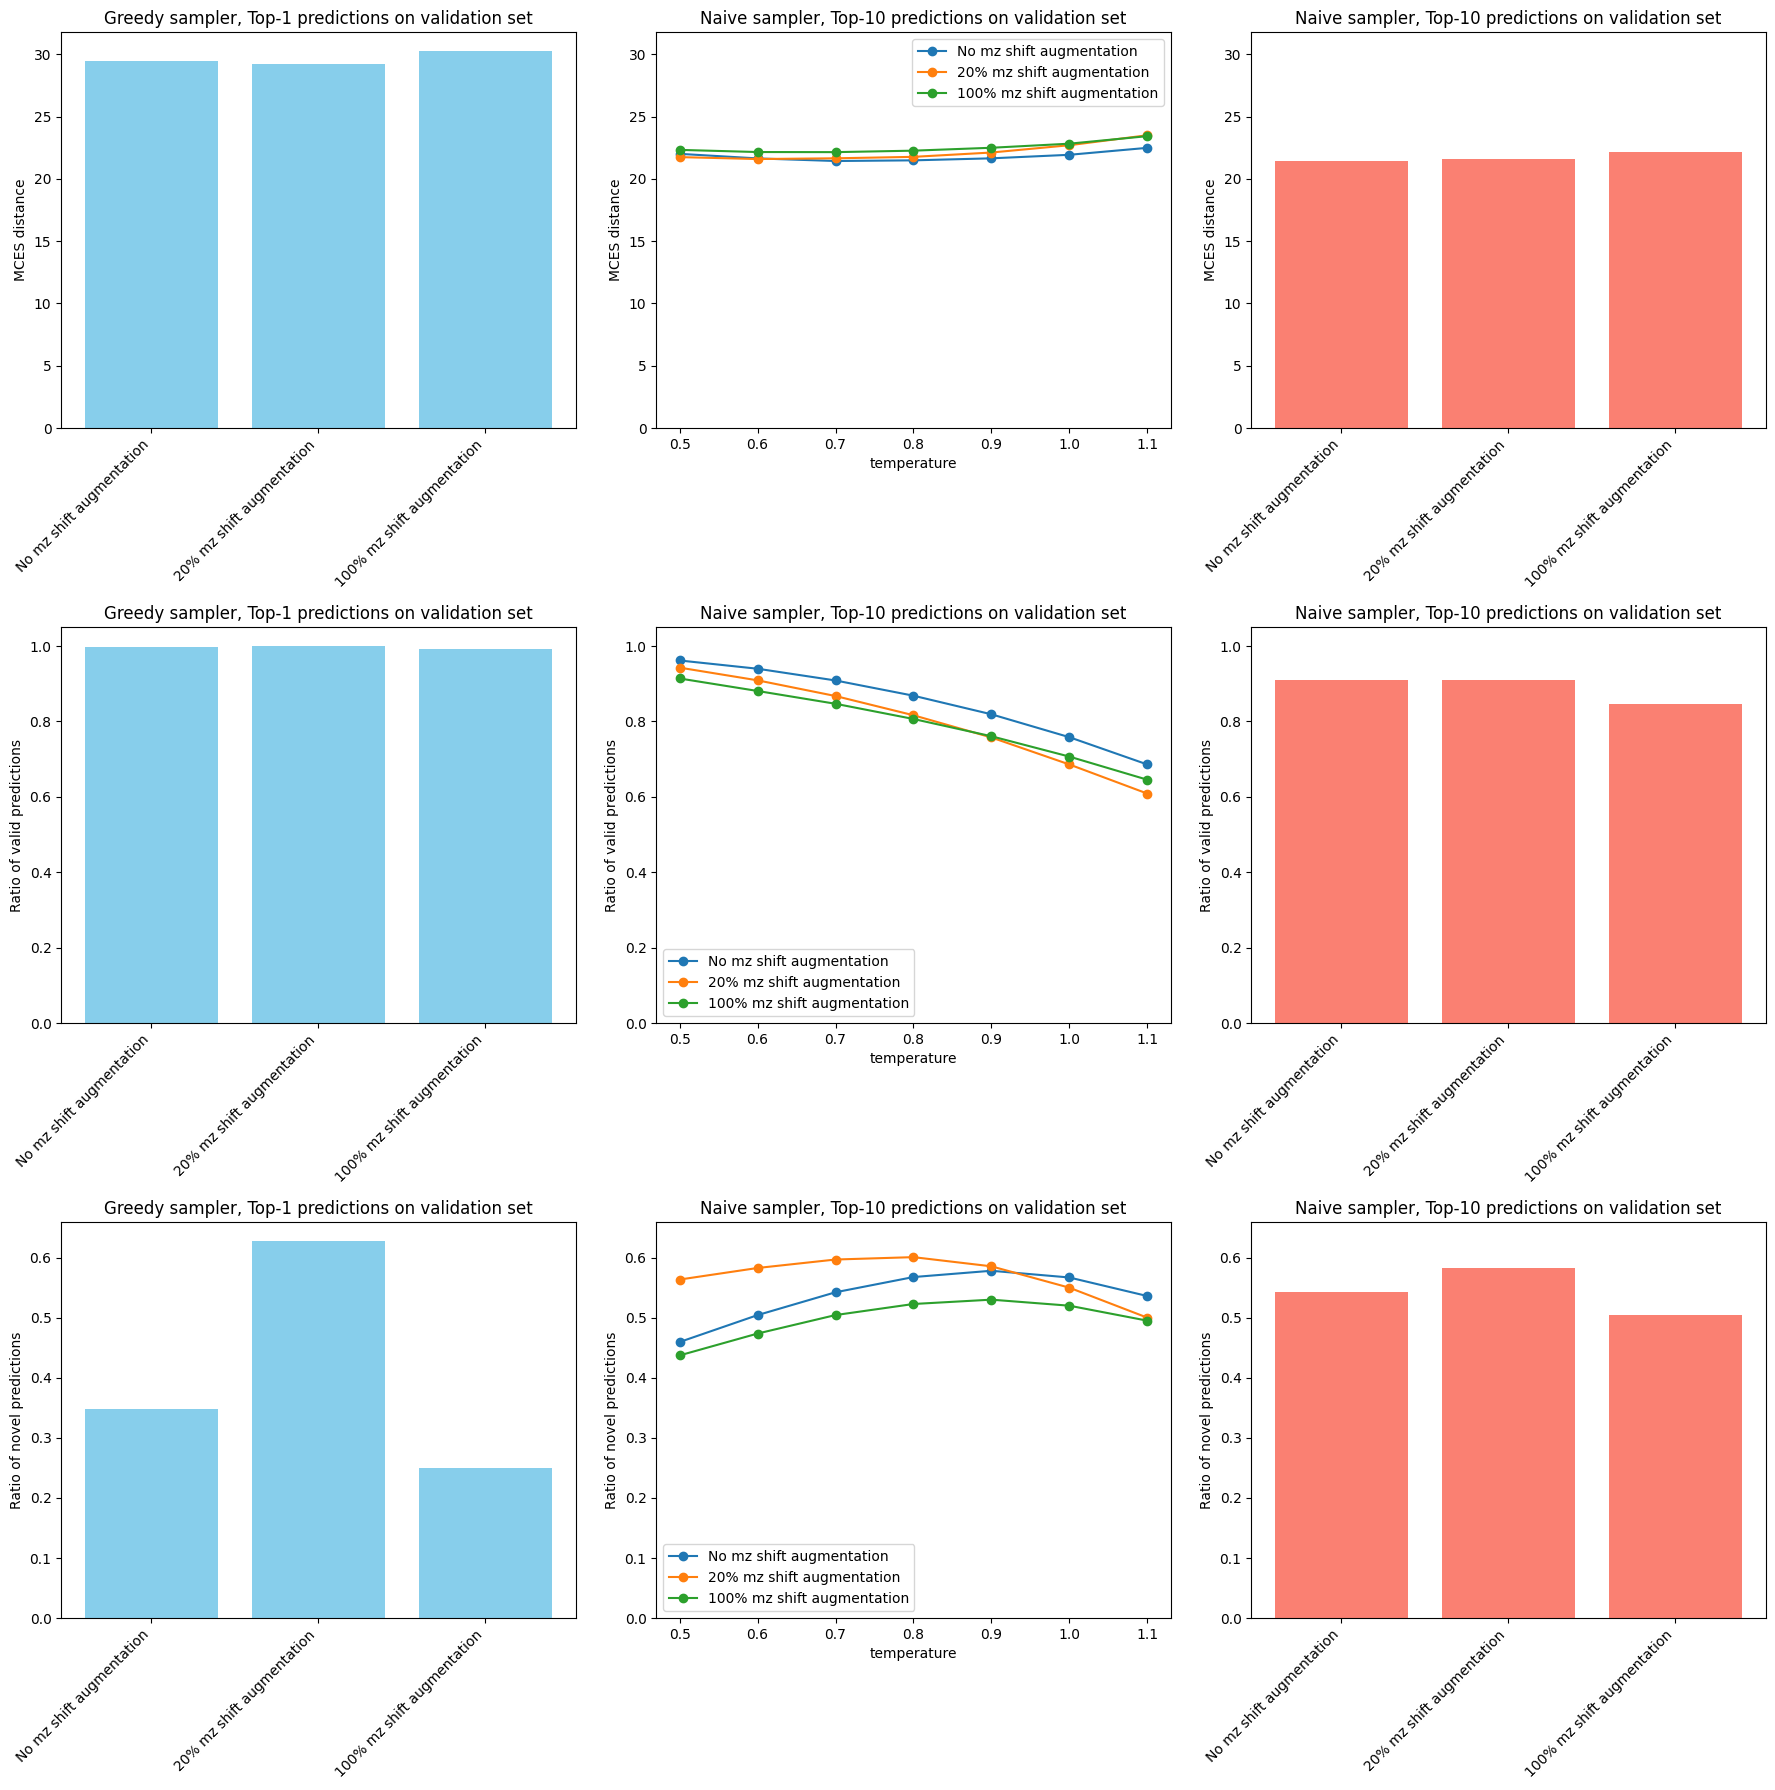

In [19]:
models = [
    'smiles_transformer_paper',
    'smiles_paper_mz_shift_augmentation_2e-1',
    'smiles_paper_mz_shift_augmentation_1'
]
names = ["No mz shift augmentation", "20% mz shift augmentation", "100% mz shift augmentation"]

compareModelsCombinedPlots(
    greedy_df, naive_df, models, names,
    "Greedy sampler, Top-1 predictions on validation set",
    "Naive sampler, Top-10 predictions on validation set",
    ["MCES distance", "Ratio of valid predictions", "Ratio of novel predictions"],
    df1_metrics=["val_top_1_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    df2_metrics=["val_top_10_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    selection_metric="val_top_10_mces_dist", best_func=min,
)

# Representations

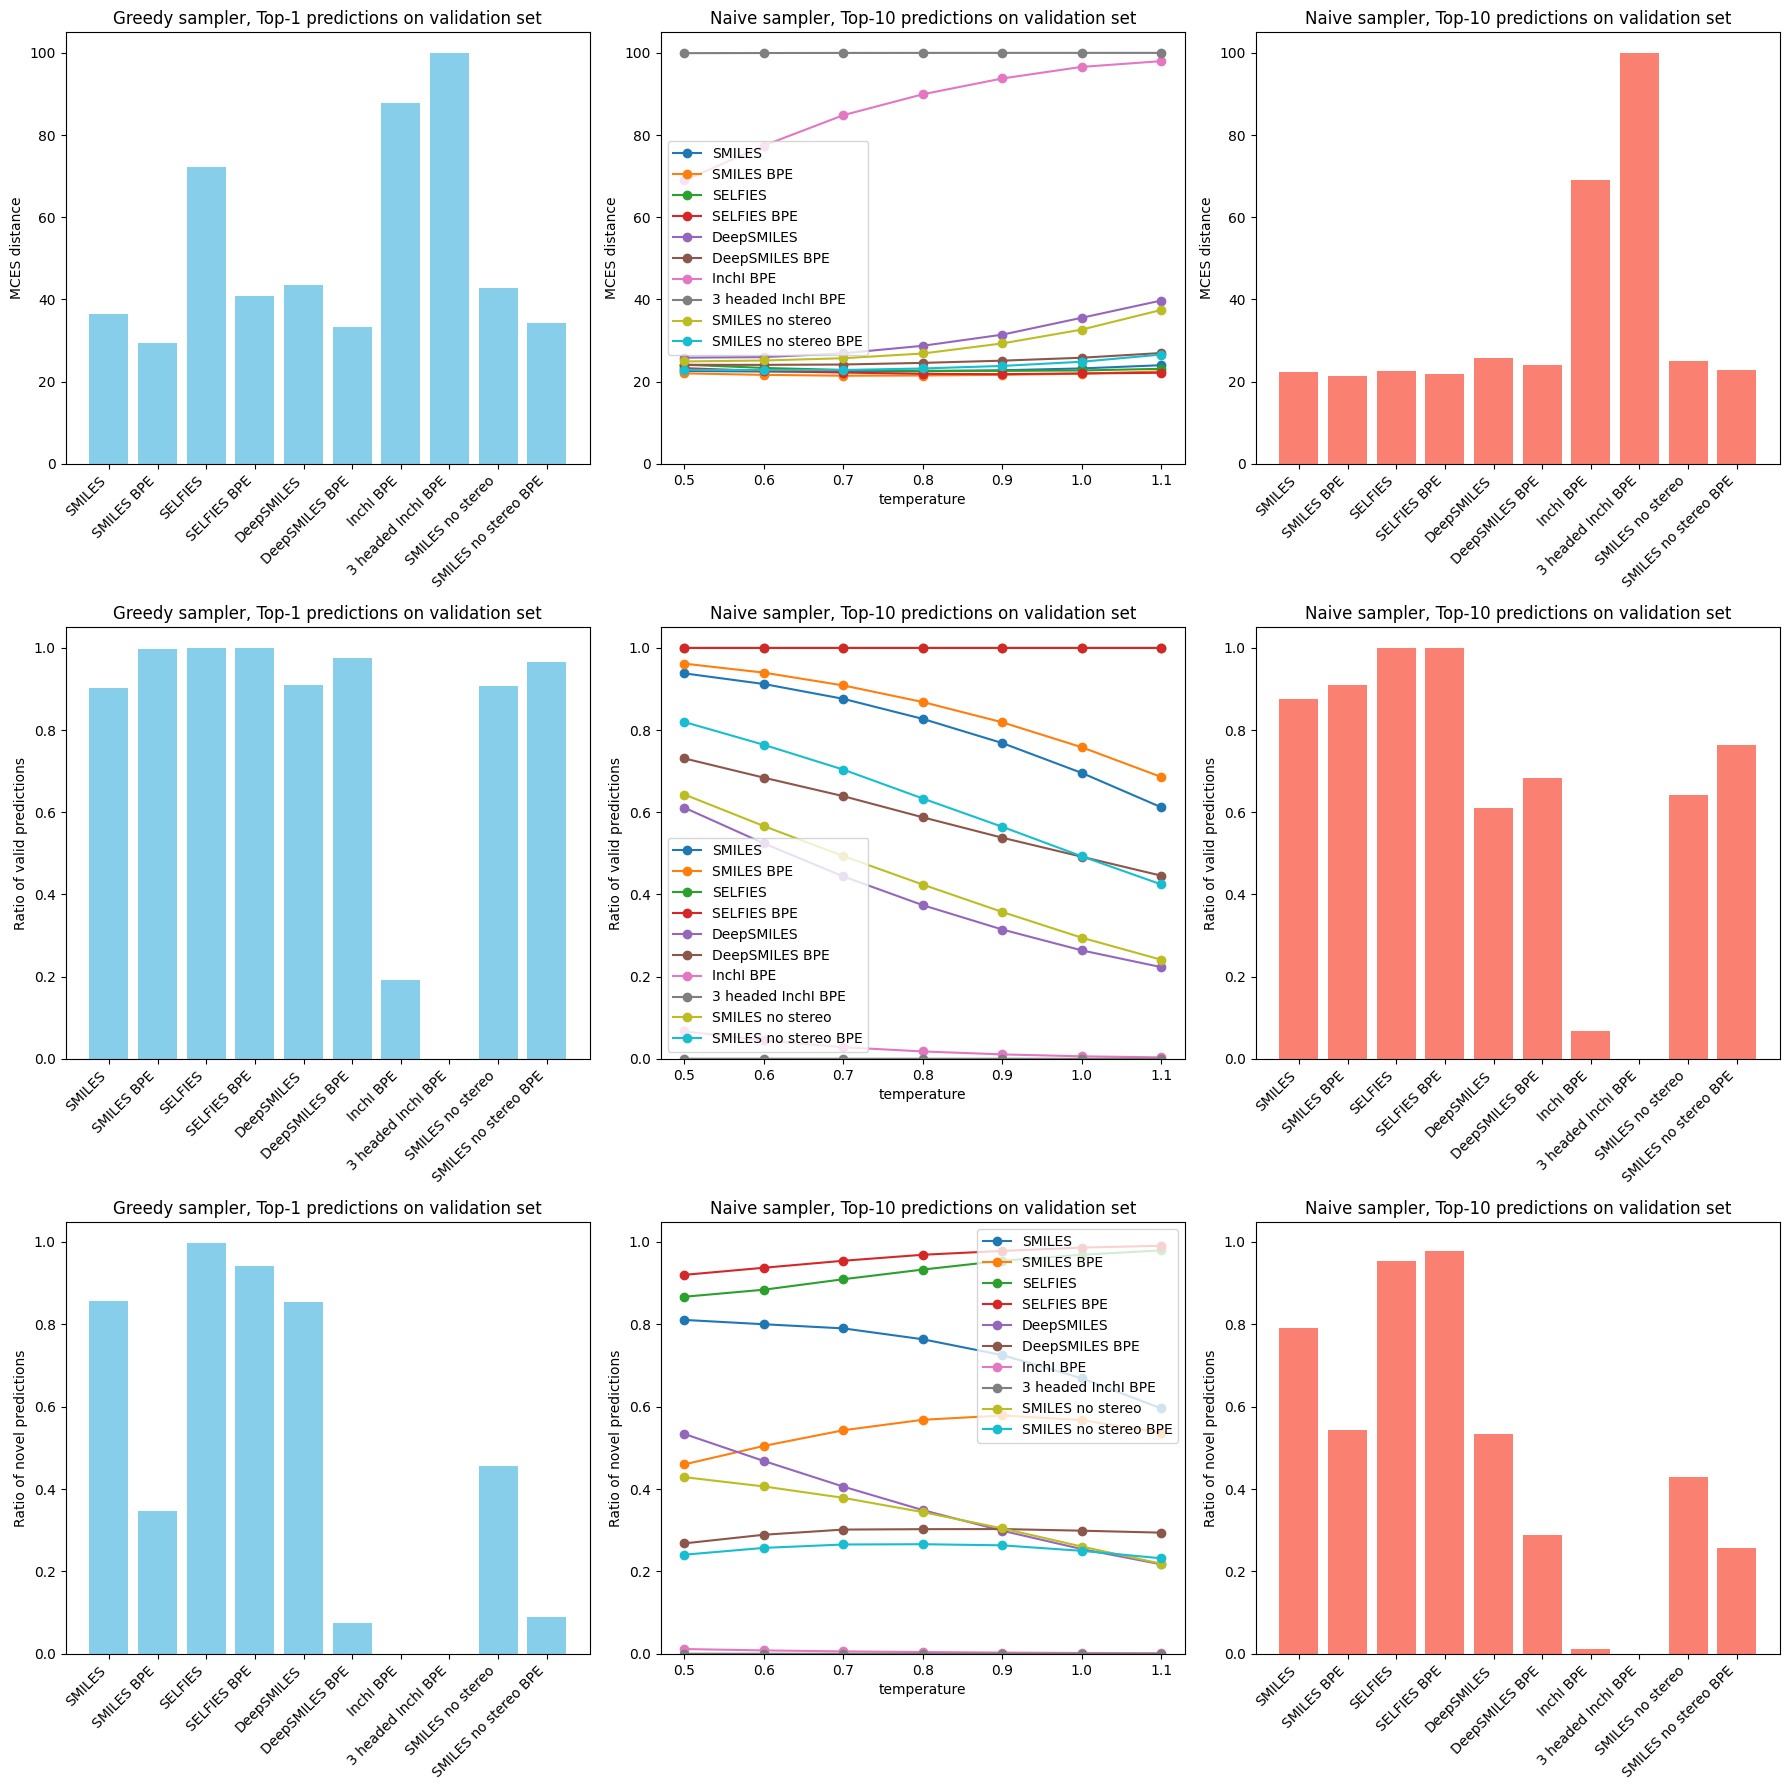

In [18]:
models = [
    'smiles_paper_bytelevel_tokenizer',
    'smiles_transformer_paper', 
    'selfies_paper', 
    'selfies_bpe_4m',
    'bytelevel_deepsmiles',
    'deepSmiles_paper', 
    'inchi_bpe_4m',
    'layered_inchi_BPE',
    'bytelevel_smiles_no_stereo',
    'smiles_4M_bpe_no_stereo',
]

names = [
    'SMILES',
    'SMILES BPE',
    'SELFIES',
    'SELFIES BPE',
    'DeepSMILES',
    'DeepSMILES BPE',
    'InchI BPE',
    '3 headed InchI BPE',
    'SMILES no stereo',
    'SMILES no stereo BPE'
]

compareModelsCombinedPlots(
    greedy_df, naive_df, models, names,
    "Greedy sampler, Top-1 predictions on validation set",
    "Naive sampler, Top-10 predictions on validation set",
    ["MCES distance", "Ratio of valid predictions", "Ratio of novel predictions"],
    df1_metrics=["val_top_1_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    df2_metrics=["val_top_10_mces_dist", "val_num_valid_mols", "val_num_novel_mols"],
    selection_metric="val_top_10_mces_dist", best_func=min,
)